In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings 
import pickle
warnings.filterwarnings("ignore") 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split  
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
  


###Importing Packages and Data

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Data Sets/LoanExport.csv")

##1.EDA & Feature Engineering

In [ ]:
df['MaturityDate']= pd.to_datetime(df['MaturityDate'], format = '%Y%m')
df['FirstPaymentDate']= pd.to_datetime(df['FirstPaymentDate'], format = '%Y%m')

In [ ]:
df['CreditScore'].replace(0,850,inplace = True)

In [ ]:
df['CreditRange'] = pd.cut(df['CreditScore'], bins = [ 0, 650, 700, 750, 900 ], labels = ['poor', 'fair', 'good', 'excellent'])
df['LTVRange'] = pd.cut(df['LTV'], bins = [ 0, 25, 50, 100 ], labels = ['low', 'medium', 'high'])
df['RepayRange'] = pd.cut(df['MonthsInRepayment'], bins = [ 0, 48, 96, 144, 192, 240 ], labels = ['0-4', '4-8', '8-12', '12-16', '16-20'])
df['LoanTenure'] = (df['MaturityDate'] - df['FirstPaymentDate']).dt.days
df = df.astype({"LoanTenure": np.float})
df['LoanTenure'] = df['LoanTenure'].div(365)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['CreditRange'] = le.fit_transform(df['CreditRange'])
df['RepayRange'] = le.fit_transform(df['RepayRange'])
df['LTVRange'] = le.fit_transform(df['LTVRange'])
df['PPM'] = le.fit_transform(df['PPM'])

In [ ]:
df

,CreditScore,FirstPaymentDate,FirstTimeHomebuyer,MaturityDate,MSA,MIP,Units,Occupancy,OCLTV,DTI,...,NumBorrowers,SellerName,ServicerName,EverDelinquent,MonthsDelinquent,MonthsInRepayment,CreditRange,LTVRange,RepayRange,LoanTenure
0,850,1999-02-01,N,2029-01-01,16974,25,1,O,89,27,...,2,FL,WASHINGTONMUTUALBANK,0,0,52,0,0,3,29.936986
1,850,1999-02-01,N,2029-01-01,19740,0,1,O,73,17,...,1,FT,CHASEHOMEFINANCELLC,0,0,144,0,0,4,29.936986
2,850,1999-02-01,N,2029-01-01,29940,0,1,O,75,16,...,2,FL,WASHINGTONMUTUALBANK,0,0,67,0,0,3,29.936986
3,850,1999-02-01,N,2029-01-01,31084,0,1,O,76,14,...,2,GM,GMACMTGECORP,0,0,35,0,0,0,29.936986
4,850,1999-02-01,N,2029-01-01,35644,0,1,O,78,18,...,2,GM,GMACMTGECORP,0,0,54,0,0,3,29.936986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291446,839,1999-03-01,N,2029-02-01,37964,0,1,O,60,32,...,2,Ot,Other servicers,0,0,12,0,0,0,29.945205
291447,840,2002-10-01,N,2029-04-01,35644,0,1,O,73,0,...,2,Ot,Other servicers,0,0,53,0,0,3,26.517808
291448,840,2003-04-01,N,2029-04-01,42044,0,1,O,73,31,...,1,Ot,Other servicers,0,0,38,0,0,0,26.019178
291449,845,1999-04-01,N,2029-03-01,37964,0,1,I,80,54,...,2,Ot,Other servicers,0,0,32,0,0,0,29.936986


In [ ]:
df1=df[df["DTI"]!=0]

In [ ]:
df1["monthly_rate"]=df1['OrigInterestRate']/(12*100)
df1["monthly_payment"]=df1['OrigUPB']* ((df1["monthly_rate"] * (1 + df1["monthly_rate"] ) ** df1["OrigLoanTerm"]) / 
    ((1 + df1["monthly_rate"]) ** df1["OrigLoanTerm"] - 1))

In [ ]:
df1.drop(['FirstPaymentDate','FirstTimeHomebuyer','MaturityDate','MSA', 'MIP', 'Units', 'Occupancy','LTV','Channel','ProductType', 'PropertyState','PropertyType', 'PostalCode', 'LoanSeqNum', 'LoanPurpose',
         'NumBorrowers', 'SellerName', 'ServicerName'],axis=1,inplace=True)

In [ ]:
df1['total_payment']= df1["monthly_payment"] * df1["OrigLoanTerm"] 
df1['interest_amount'] = df1['total_payment'] - df1['OrigUPB']
df1["monthly_income"]=df1["monthly_payment"]*100/df1["DTI"]

In [ ]:
def principal(monthly_rate,amount,emi,month):
  for i in range(month):
    interest=monthly_rate*amount
    p=emi-interest
    amount-=p
  return amount


In [ ]:
  df1["cur_principal"]=np.vectorize(principal)(df1["monthly_rate"],df1['OrigUPB'],df1["monthly_payment"],df1["MonthsInRepayment"])


In [ ]:
def prepay(dti,income,EverDelinquent,monthly_payment):
  if(EverDelinquent==0):
    if(dti<40):
      p=income/2
    else:
      p=income*3/4
    p=p-monthly_payment*24
    return p
  else:
    p=0
    return p

df1["prepayment"]=np.vectorize(prepay)(df1["DTI"],df1['monthly_income']*24,df1["EverDelinquent"],df1["monthly_payment"])

df1["new_principal"]=df1["cur_principal"]-df1["prepayment"]

In [ ]:
df1.head(10)

,CreditScore,OCLTV,DTI,OrigUPB,OrigInterestRate,PPM,OrigLoanTerm,EverDelinquent,MonthsDelinquent,MonthsInRepayment,...,RepayRange,LoanTenure,monthly_rate,monthly_payment,total_payment,interest_amount,monthly_income,cur_principal,prepayment,new_principal
0,850,89,27,117000,6.750,0,360,0,0,52,...,3,29.936986,0.005625,758.859773,273189.518275,156189.518275,2810.591752,110934.868922,15514.466470,95420.402452
1,850,73,17,109000,6.500,0,360,0,0,144,...,4,29.936986,0.005417,688.954146,248023.492419,139023.492419,4052.671445,87590.650220,32097.157842,55493.492378
2,850,75,16,88000,6.875,0,360,0,0,67,...,3,29.936986,0.005729,578.097356,208115.048172,120115.048172,3613.108475,81982.427803,29482.965158,52499.462645
3,850,76,14,160000,6.875,0,360,0,0,35,...,0,29.936986,0.005729,1051.086102,378390.996677,218390.996677,7507.757871,154806.854416,64867.028002,89939.826414
4,850,78,18,109000,7.125,0,360,0,0,54,...,3,29.936986,0.005938,734.353190,264367.148543,155367.148543,4079.739947,103470.092916,31332.402790,72137.690126
5,850,89,40,207000,7.125,0,360,0,0,42,...,0,29.936986,0.005938,1394.597343,502055.043564,295055.043564,3486.493358,199130.237052,29286.544208,169843.692844
6,850,90,21,111000,6.875,0,360,0,0,44,...,0,29.936986,0.005729,729.190983,262508.753945,151508.753945,3472.338015,106348.399957,24167.472585,82180.927372
7,850,72,20,97000,6.750,0,360,1,3,145,...,1,29.936986,0.005625,629.140154,226490.455322,129490.455322,3145.700768,78360.491200,0.000000,78360.491200
8,850,95,38,55000,7.000,1,345,0,0,64,...,3,28.682192,0.005833,370.664718,127879.327577,72879.327577,975.433467,51147.375583,2809.248386,48338.127196
9,850,95,27,35000,7.125,0,360,1,104,212,...,2,29.936986,0.005938,235.801483,84888.533936,49888.533936,873.338827,23177.755505,0.000000,23177.755505


In [ ]:
def tenure(monthly_rate,amount,emi):
  c=0
  while(1):
    interest=monthly_rate*amount
    p=emi-interest
    amount-=p
    c+=1
    if(amount<0):
      break
  return c-1



In [ ]:
df1["rest_tenure"]=np.vectorize(tenure)(df1["monthly_rate"],df1['new_principal'],df1["monthly_payment"])
df1['new_tenure']=df1["rest_tenure"]+df1['MonthsInRepayment']

In [ ]:
def new_interest1(monthly_rate,amount,emi,month):
  t_i=0
  for i in range(month):
    interest=monthly_rate*amount
    p=emi-interest
    amount-=p
    t_i+=interest
  return t_i
def new_interest2(monthly_rate,amount,emi,month):
  t_i=0
  for i in range(month-1):
    interest=monthly_rate*amount
    p=emi-interest
    amount-=p
    t_i+=interest
  return t_i


In [ ]:
df1["intrest_b_p"]=np.vectorize(new_interest1)(df1["monthly_rate"],df1['OrigUPB'],df1["monthly_payment"],df1["MonthsInRepayment"])
df1["intrest_a_p"]=np.vectorize(new_interest2)(df1["monthly_rate"],df1['new_principal'],df1["monthly_payment"],df1["rest_tenure"])
df1['new_tot_interest']=df1["intrest_b_p"]+df1["intrest_a_p"]
df1.drop(['monthly_rate','monthly_income','cur_principal','new_principal', 'rest_tenure','intrest_b_p',
       'intrest_a_p'],axis=1,inplace=True)
df1["loss_tb"]=df1['interest_amount']-df1['new_tot_interest']
df1["ROI"]=df1['interest_amount']/df1["total_payment"]
df1["Prefered_Roi"]=(df1["new_tot_interest"]+(df1["loss_tb"]/2))/(df1["new_tot_interest"]+(df1["loss_tb"]/2)+df1['OrigUPB'])

In [ ]:
df1.columns

Index(['CreditScore', 'OCLTV', 'DTI', 'OrigUPB', 'OrigInterestRate', 'PPM',
       'OrigLoanTerm', 'EverDelinquent', 'MonthsDelinquent',
       'MonthsInRepayment', 'CreditRange', 'LTVRange', 'RepayRange',
       'LoanTenure', 'monthly_payment', 'total_payment', 'interest_amount',
       'prepayment', 'new_tenure', 'new_tot_interest', 'loss_tb', 'ROI',
       'Prefered_Roi'],
      dtype='object')

In [ ]:
df1.drop(['total_payment','interest_amount'],axis=1,inplace=True)


##2. X,y split

In [ ]:
X=df1.drop(['EverDelinquent','Prefered_Roi','prepayment'],axis=1)
y=df1[['EverDelinquent','Prefered_Roi','prepayment']]

for colname in X.select_dtypes('float64'):
    X[colname], _ = X[colname].factorize()
discrete_features = X.dtypes == np.int64


##3. Feature Selection

In [ ]:
# Calculating MI scores for data set Features
xx=df1.drop(['EverDelinquent'],axis=1)
yy=df1['EverDelinquent']

for colname in xx.select_dtypes('float64'):
    xx[colname], _ = xx[colname].factorize()
discrete_features = xx.dtypes == np.int64


from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(xx, yy)
mi_scores = pd.Series(mi_scores,name="MI Scores", index=xx.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

MonthsDelinquent     0.502737
prepayment           0.502383
new_tenure           0.500807
Prefered_Roi         0.486410
loss_tb              0.311937
new_tot_interest     0.311912
OrigLoanTerm         0.043155
CreditRange          0.042703
CreditScore          0.034868
RepayRange           0.033623
MonthsInRepayment    0.031821
LoanTenure           0.010803
OCLTV                0.006335
OrigInterestRate     0.004873
ROI                  0.004240
monthly_payment      0.003922
OrigUPB              0.003521
DTI                  0.002357
LTVRange             0.000610
PPM                  0.000510
Name: MI Scores, dtype: float64

##4. Train,Test Split

In [ ]:
X=df1.drop(['EverDelinquent','Prefered_Roi','prepayment'],axis=1)
y=df1[['EverDelinquent','Prefered_Roi','prepayment']]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=1)

# Separating Target values for classifications and regression problems
y_class_train = y_train.iloc[:,0]
y_class_test = y_test.iloc[:,0]

y_reg_test = y_test.iloc[:,1:]
y_reg_train = y_train.iloc[:,1:]

##5. Data Preprocessing

In [ ]:
#Applying SMOTE for handling imbalance data
smote = SMOTE()
#checking shape of the data
from collections import Counter
print("Before Over Sampling shape of X_train :" , X_train.shape)
print("Before Over Sampling shape of y_train :" , y_class_train.shape)
counter = Counter(y_class_train)
print('Before',counter)
#Applying SMOTE for handling Imbalance data.
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_class_train)
print("After Over Sampling shape of X_train :", X_train_sm.shape)
print("After Over Sampling shape of y_train :", y_train_sm.shape)
counter = Counter(y_train_sm)
print('After',counter)
scaler = MinMaxScaler()

Before Over Sampling shape of X_train : (218924, 18)
Before Over Sampling shape of y_train : (218924,)
Before Counter({0: 174792, 1: 44132})
After Over Sampling shape of X_train : (349584, 18)
After Over Sampling shape of y_train : (349584,)
After Counter({0: 174792, 1: 174792})


##Classification Pipeline

In [ ]:
#@title Logistic Regression 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
X_train.head()

In [ ]:
#instantiate the model
log_reg = LogisticRegression()


model_log_reg = Pipeline([
    ('my_scalar', MinMaxScaler()),
    ('pca', PCA(n_components=7)),
    ('log_reg', log_reg)
]) 

#fit the model using the training data
model_log_reg.fit(X_train,y_class_train)

#use model to make predictions on test data
y_pred = model_log_reg.predict(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

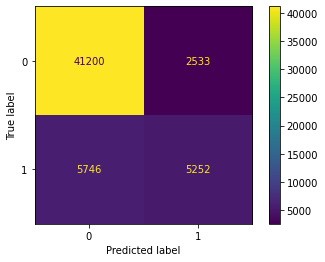

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_log_reg,X_test,y_class_test)
plt.show

In [ ]:
from sklearn.metrics import accuracy_score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_class_test, y_pred)))

Model accuracy score: 0.8487


In [ ]:
print('Predicted value of y1 is:', y_pred)

Predicted value of y1 is: [0 0 0 ... 0 0 0]


Using Logistic Regression we have achieved 85% accuracy for testing data

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_class_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     43733
           1       0.67      0.48      0.56     10998

    accuracy                           0.85     54731
   macro avg       0.78      0.71      0.73     54731
weighted avg       0.84      0.85      0.84     54731



AUC: 0.8928705779034491


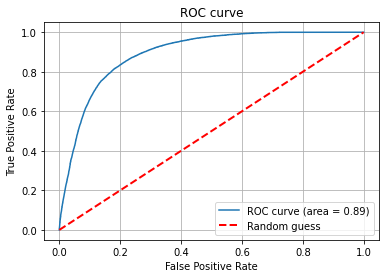

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_class_test, model_log_reg.predict(X_test))
fpr, tpr, thresholds = metrics.roc_curve(y_class_test, model_log_reg.predict_proba(X_test)[:,1])
auc = metrics.auc(fpr, tpr)
print("AUC:", auc)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle = '--', lw=2, color = 'r', label = 'Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_log_reg, X, df1[['EverDelinquent']], cv= 10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.65595995 0.80223635 0.80858761 0.81173031 0.81374699 0.82985566
 0.84202448 0.84838297 0.85145801 0.8524081 ]
0.8116390432691448


##Ridge Regression

In [ ]:


# training model with 0.5 alpha value
ridg = Ridge(alpha = 0.5, normalize = False, tol = 0.001, \
              solver ='auto', random_state = 1)
model_ridg = Pipeline([
    ('my_scalar', StandardScaler()),
    ('Ridge_reg',ridg)
]) 

model_ridg.fit(X_train, y_reg_train)
  
# predicting the y_test
y_pred = model_ridg.predict(X_test)
  
# finding score for our model
score = model_ridg.score(X_test, y_reg_test)
print("\n\nModel score : ", score)



Model score :  0.7818454895263768


Using Ridge Regression we have achieved 78% accuracy for testing data

In [ ]:
X_test.columns

Index(['CreditScore', 'OCLTV', 'DTI', 'OrigUPB', 'OrigInterestRate', 'PPM',
       'OrigLoanTerm', 'MonthsDelinquent', 'MonthsInRepayment', 'CreditRange',
       'LTVRange', 'RepayRange', 'LoanTenure', 'monthly_payment', 'new_tenure',
       'new_tot_interest', 'loss_tb', 'ROI'],
      dtype='object')

##Saving Model

In [ ]:
#pickle.dump(model_ridg, open('/content/drive/MyDrive/models/ridge.pkl','wb'))
#pickle.dump(model_log_reg, open('/content/drive/MyDrive/models/log_reg.pkl','wb'))

In [ ]:
# to load the model :
# pickled_model = pickle.load(open('model.pkl', 'rb'))
# pickled_model.predict(X_test)